In [18]:
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize
from scipy.stats import logistic
from os.path import join
from tqdm import tqdm
from PIL import Image
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, Lambda, Convolution2D, MaxPooling2D, Flatten
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import ResNet50, preprocess_input
import os
import matplotlib.pyplot as plt


In [3]:
%matplotlib inline

In [4]:
batch_size = 24
embedding_dim = 50
image_size = 224
path_base = '/home/cy/whale_data/'
path_train = join(path_base,'train')
path_test = join(path_base,'test')
path_model = join(path_base,'MyModel.hdf5')
path_csv = '/home/cy/whale_data/train.csv'

In [5]:
class sample_gen(object):
    # file_class_mapping：key：图片名，value：Id
    def __init__(self, file_class_mapping, other_class = "new_whale"):
        self.file_class_mapping= file_class_mapping
        # <class 'list'>, {'w_a232f9e': ['33c25291.jpg', '67c96540.jpg'], 'w_1b6d171': ['64c99b7b.jpg'],
        self.class_to_list_files = defaultdict(list)
        # 其他类别图片名
        self.list_other_class = []
        # 所有图片的文件名
        self.list_all_files = list(file_class_mapping.keys())
        # 训练集就是0~6894的数字list
        self.range_all_files = list(range(len(self.list_all_files)))
        

        for file, class_ in file_class_mapping.items():
            if class_ == other_class:
                self.list_other_class.append(file)
            else:
                self.class_to_list_files[class_].append(file)

        # 无重复Id list
        self.list_classes = list(set(self.file_class_mapping.values()))
        # 上面list的下标索引
        self.range_list_classes= range(len(self.list_classes))
        self.class_weight = np.array([len(self.class_to_list_files[class_]) for class_ in self.list_classes])
        # 每个ID所占比例
        self.class_weight = self.class_weight/np.sum(self.class_weight)
        

    def get_sample(self):
        # 选一个id的位置下标，按照id的权重选
        class_idx = np.random.choice(self.range_list_classes, 1, p=self.class_weight)[0]
        # 从这个class名中随机选2个图片在class_to_list_files[class]中的位置，有重复（如[0,0]）因为有的类只有张图片
        examples_class_idx = np.random.choice(range(len(self.class_to_list_files[self.list_classes[class_idx]])), 2)
        # 得到两个正样本图片名（可能相同）
        positive_example_1, positive_example_2 = \
            self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[0]],\
            self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[1]]

        negative_example = None
        # 负样本选择只要和正样本不同类即可
        while negative_example is None or self.file_class_mapping[negative_example] == \
                self.file_class_mapping[positive_example_1]:
            negative_example_idx = np.random.choice(self.range_all_files, 1)[0]
            negative_example = self.list_all_files[negative_example_idx]
        #返回的都是图片名
        return positive_example_1, negative_example, positive_example_2
    
def read_and_resize(filepath):
    im = Image.open((filepath)).convert('RGB')
    im = im.resize((image_size, image_size))
    return np.array(im, dtype="float32")
    

# 0.1概率翻转
def augment(im_array):
    if np.random.uniform(0, 1) > 0.9:
        im_array = np.fliplr(im_array)
    return im_array

def gen(triplet_gen):
    while True:
        list_positive_examples_1 = []
        list_negative_examples = []
        list_positive_examples_2 = []

        for i in range(batch_size):
            positive_example_1, negative_example, positive_example_2 = triplet_gen.get_sample()
            path_pos1 = join(path_train, positive_example_1)
            path_neg = join(path_train, negative_example)
            path_pos2 = join(path_train, positive_example_2)
            
            positive_example_1_img = read_and_resize(path_pos1)
            negative_example_img = read_and_resize(path_neg)
            positive_example_2_img = read_and_resize(path_pos2)

            positive_example_1_img = augment(positive_example_1_img)
            negative_example_img = augment(negative_example_img)
            positive_example_2_img = augment(positive_example_2_img)

            
            list_positive_examples_1.append(positive_example_1_img)
            list_negative_examples.append(negative_example_img)
            list_positive_examples_2.append(positive_example_2_img)

        A = preprocess_input(np.array(list_positive_examples_1))
        B = preprocess_input(np.array(list_positive_examples_2))
        C = preprocess_input(np.array(list_negative_examples))
        
        label = None
        
        yield ({'anchor_input': A, 'positive_input': B, 'negative_input': C}, label)

In [6]:
def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    # shape (10,4096)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        # shape (10,1)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        #shape (10,1)
        loss = K.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)

def triplet_loss_np(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = np.square(anchor - positive)
    negative_distance = np.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = np.sqrt(np.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = np.sqrt(np.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = np.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = np.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = np.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = np.log(1 + np.exp(loss))
    return np.mean(loss)

def check_loss():
    batch_size = 10
    shape = (batch_size, 4096)

    p1 = normalize(np.random.random(shape))
    n = normalize(np.random.random(shape))
    p2 = normalize(np.random.random(shape))
    
    input_tensor = [K.variable(p1), K.variable(n), K.variable(p2)]
    out1 = K.eval(triplet_loss(input_tensor))
    input_np = [p1, n, p2]
    out2 = triplet_loss_np(input_np)

    assert out1.shape == out2.shape
    print(np.linalg.norm(out1))
    print(np.linalg.norm(out2))
    print(np.linalg.norm(out1-out2))

In [7]:
check_loss()

0.999901
0.999900853867
3.59954939189e-08


In [8]:
def GetModel():
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='max')
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = Dropout(0.6)(x)
    x = Dense(embedding_dim)(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    embedding_model = Model(base_model.input, x, name="embedding")

    input_shape = (image_size, image_size, 3)
    anchor_input = Input(input_shape, name='anchor_input')
    positive_input = Input(input_shape, name='positive_input')
    negative_input = Input(input_shape, name='negative_input')
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    inputs = [anchor_input, positive_input, negative_input]
    outputs = [anchor_embedding, positive_embedding, negative_embedding]
       
    triplet_model = Model(inputs, outputs)
    triplet_model.add_loss(K.mean(triplet_loss(outputs)))

    return embedding_model, triplet_model

In [9]:
data = pd.read_csv(path_csv)
train, test = train_test_split(data, train_size=0.7, random_state=1337)
file_id_mapping_train = {k: v for k, v in zip(train.Image.values, train.Id.values)}
file_id_mapping_test = {k: v for k, v in zip(test.Image.values, test.Id.values)}
gen_tr = gen(sample_gen(file_id_mapping_train))
gen_te = gen(sample_gen(file_id_mapping_test))

checkpoint = ModelCheckpoint(path_model, monitor='loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=2)
callbacks_list = [checkpoint, early]  # early

(224, 224, 3)


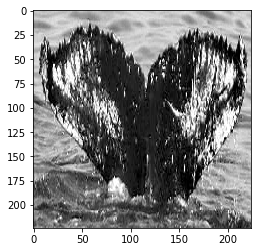

(224, 224, 3)


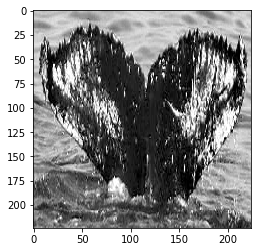

In [10]:
def ShowImg(img):
    plt.figure()
    plt.imshow(img.astype('uint8'))
    plt.show()
    plt.close()
    
batch = next(gen_tr)
img = batch[0]['anchor_input'][12]

#/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/applications/imagenet_utils.py in preprocess_input(x, data_format)
#x[:, :, :, 0] -= 103.939
#x[:, :, :, 1] -= 116.779
#x[:, :, :, 2] -= 123.68
mean = [103.939, 116.779, 123.68]
img[..., 0] += mean[0]
img[..., 1] += mean[1]
img[..., 2] += mean[2]
print(img.shape)
ShowImg(img)
img = img[..., ::-1]
print(img.shape)
ShowImg(img)

In [11]:
a = np.array([ [[1,2,3] , [4,5,6] ],
              [[7,8,9] , [10,11,12] ] ])
print(a.shape)
a[..., 2] += 100
a = a[:,:,::-1]
print(a)


(2, 2, 3)
[[[103   2   1]
  [106   5   4]]

 [[109   8   7]
  [112  11  10]]]


# Installation of Resnet 50 Weight to keras

In [12]:
!ls /home/cy/notebook/resnet50_keras/

imagenet_class_index.json
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


In [13]:
cache_dir  = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [14]:
!cp /home/cy/notebook/resnet50_keras/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5 ~/.keras/models/

In [15]:
!ls ~/.keras/models

ResNet-50-model.keras.h5  resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


In [17]:
embedding_model, triplet_model = GetModel()

TypeError: l2_normalize() got an unexpected keyword argument 'axis'

In [ ]:
for i, layer in enumerate(embedding_model.layers):
    print(i, layer.name, layer.trainable)

In [ ]:
for layer in embedding_model.layers[175:]:
    layer.trainable = True
for layer in embedding_model.layers[:175]:
    layer.trainable = False

In [ ]:
triplet_model.compile(loss=None, optimizer=Adam(0.01))
'''
history = triplet_model.fit_generator(gen_tr, 
                              validation_data=gen_te, 
                              epochs=4, 
                              verbose=1, 
                              workers=1,
                              steps_per_epoch=200, 
                              validation_steps=20)
'''
history = triplet_model.fit_generator(gen_tr, 
                              validation_data=gen_te, 
                              epochs=1, 
                              verbose=1, 
                              workers=1,
                              steps_per_epoch=100, 
                              validation_steps=20)

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

In [ ]:
for layer in embedding_model.layers[150:]:
    layer.trainable = True
for layer in embedding_model.layers[:150]:
    layer.trainable = False
triplet_model.compile(loss=None, optimizer=Adam(0.0001))
'''
history = triplet_model.fit_generator(gen_tr, 
                                    validation_data=gen_te, 
                                    epochs=3, 
                                    verbose=1, 
                                    workers=1,
                                    steps_per_epoch=70, 
                                    validation_steps=30)
'''
history = triplet_model.fit_generator(gen_tr, 
                                    validation_data=gen_te, 
                                    epochs=1, 
                                    verbose=1, 
                                    workers=1,
                                    steps_per_epoch=70, 
                                    validation_steps=10)

In [ ]:
plt.plot(history.history['loss'], label='traning_loss')
plt.plot(history.history['val_loss'], label='validation_loss', color = 'r')
plt.legend()
plt.show()

In [ ]:
# 返回：fnames：包含文件名的list imgs：图片resize后的np.array 16*224*224*3
# 长度都为16
def data_generator(fpaths, batch=16):
    i = 0
    imgs = []
    fnames = []
    for path in fpaths:
        if i == 0:
            imgs = []
            fnames = []
        i += 1
        img = read_and_resize(path)
        imgs.append(img)
        fnames.append(os.path.basename(path))
        if i == batch:
            i = 0
            imgs = np.array(imgs)
            yield fnames, imgs
            
    if i != 0:
        imgs = np.array(imgs)
        yield fnames, imgs
        
    raise StopIteration()

In [ ]:
data = pd.read_csv(path_csv)
file_id_mapping = {k: v for k, v in zip(data.Image.values, data.Id.values)}
import glob
#文件名的list
train_files = glob.glob(join(path_train, '*.jpg'))
test_files = glob.glob(join(path_test, '*.jpg'))

In [ ]:
train_preds  = []
train_file_names = []
for fnames, imgs in tqdm(data_generator(train_files, batch=32)):
    predicts = embedding_model.predict(imgs)
    # predicts.shape = (32,50)
    predicts = predicts.tolist()
    train_preds += predicts
    train_file_names += fnames
# print(train_preds.shape) (9850,50)
train_preds = np.array(train_preds)


In [ ]:
test_preds = []
test_file_names = []
for fnames, imgs in tqdm(data_generator(test_files, batch=32)) :
    predicts = embedding_model.predict(imgs)
    predicts = predicts.tolist()
    test_preds += predicts
    test_file_names += fnames
test_preds = np.array(test_preds)

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(train_preds)

In [ ]:
distances_test, neighbors_test = neigh.kneighbors(test_preds)
distances_test, neighbors_test = distances_test.tolist(), neighbors_test.tolist()

In [ ]:
preds_str = []

for filepath, distance, neighbour_ in zip(test_file_names, distances_test, neighbors_test):
    sample_result = []
    sample_classes = []
    for d, n in zip(distance, neighbour_):
        train_file = train_files[n].split(os.sep)[-1]
        class_train = file_id_mapping[train_file]
        sample_classes.append(class_train)
        sample_result.append((class_train, d))

    if "new_whale" not in sample_classes:
        sample_result.append(("new_whale", 0.1))
    sample_result.sort(key=lambda x: x[1])
    sample_result = sample_result[:5]
    preds_str.append(" ".join([x[0] for x in sample_result]))

In [ ]:
preds_str

In [ ]:
df = pd.DataFrame()
df['Image'] = [x.split(os.sep)[-1] for x in test_file_names]
df["Id"] = [i for i in preds_str]
df.to_csv("sub.csv", index=False)